In [1]:
# Imports 
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import Sarimax model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import sklearn RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
# Import MAE
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from pmdarima.arima import ndiffs, nsdiffs 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

C:\Users\alexa\AppData\Roaming\Python\Python39\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Load data
df_prod = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-PROD.csv")
df_cons = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-CONS.csv")

df_prod_2_year_cons = pd.read_csv('data/year_coverage_consumption_100.csv')
df_prod_2_year_prod = pd.read_csv('data/year_coverage_production_100.csv')

df_prod_2_year_prod = df_prod_2_year_prod[df_prod_2_year_prod["time_between_first_last"] >= 2]
df_prod_2_year_cons = df_prod_2_year_cons[df_prod_2_year_cons["time_between_first_last"] >= 2]

# Sort by time_between_first_last
df_prod_2_year_cons = df_prod_2_year_cons.sort_values(by=['time_between_first_last'], ascending=False)
df_prod_2_year_prod = df_prod_2_year_prod.sort_values(by=['time_between_first_last'], ascending=False)

In [3]:
#Series stuff
def get_series(meter_id, type="prod", start=None, end=None, agg=None):
    """Create Series from meter_id and type of data

    Args:
        meter_id (str): meter-id
        type (str, optional): production or consumption of kwh. Defaults to "prod".
        start (str, optional): timeslot to start series. Defaults to None.
        end (str, optional): timeslot to end series. Defaults to None.
        agg (str, optional): aggregation of data. One of day, week or month. Defaults to None.

    Returns:
        pd.series: series of filtered data
    """

    print("Getting series for meter_id: {}".format(meter_id))

    # if start not none
    if start is not None:
        # Convert to datetime
        start = pd.to_datetime(start)
    
    # if end not none
    if end is not None:
        # Convert to datetime
        end = pd.to_datetime(end)

    if type == "prod":
        df_return = df_prod[df_prod["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh
        df_return = df_return[['timeslot', 'num_kwh']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    elif type == "cons":
        df_return = df_cons[df_cons["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh
        df_return = df_return[['timeslot', 'num_kwh']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    df_return = df_return.set_index("timeslot").sort_index()

    # If agg is not none
    if agg is not None:
        if agg == "day":
            df_return = df_return.resample("D").sum()
        elif agg == "week":
            df_return = df_return.resample("W").sum()
        elif agg == "month":
            df_return = df_return.resample("M").sum()
        else:
            print("Aggregation not supported")
            return None

    # Return series
    return df_return

def moving_average(timeseries, window):
    return timeseries.rolling(window=window, center=True).mean()

In [4]:
# Cut data to only use the first year
series = get_series("e882f9a7-f1de-4419-9869-7339be303281",
                        type="prod",
                        start=None,
                        end=None,
                        agg=None)
print(series.head(10))

Getting series for meter_id: e882f9a7-f1de-4419-9869-7339be303281
                           num_kwh
timeslot                          
2016-11-14 23:00:00+00:00      0.0
2016-11-15 00:00:00+00:00      0.0
2016-11-15 01:00:00+00:00      0.0
2016-11-15 02:00:00+00:00      0.0
2016-11-15 03:00:00+00:00      0.0
2016-11-15 04:00:00+00:00      0.0
2016-11-15 05:00:00+00:00      0.0
2016-11-15 06:00:00+00:00      0.0
2016-11-15 07:00:00+00:00      0.0
2016-11-15 08:00:00+00:00      0.0


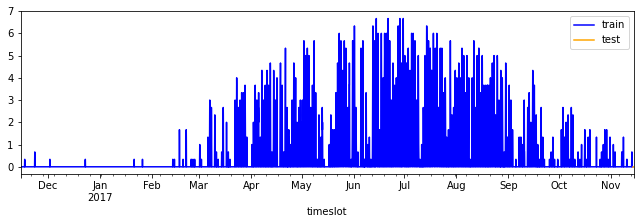

In [5]:
units_to_forecast = 24

train_series = series.copy()
train_series['year']=train_series.index.year
train_series['month']=train_series.index.month
train_series['week']=train_series.index.week
train_series['weekday']=train_series.index.weekday
train_series['hour']=train_series.index.hour

train = train_series[:24*365-units_to_forecast]
test = train_series[24*365-units_to_forecast:24*365]


fig, ax=plt.subplots(figsize=(11, 3))
moving_average(train['num_kwh'], 3).sort_index().plot(ax=ax, label='train', color='blue')
moving_average(test['num_kwh'], 1).sort_index().plot(ax=ax, label='test', color='orange')
ax.legend();

In [6]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 24
                )

forecaster.fit(y=train['num_kwh'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 8735] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-14 14:22:18 
Last fit date: 2022-06-14 14:22:22 
Skforecast version: 0.4.3 

Test error (mse): 0.011020118068380541


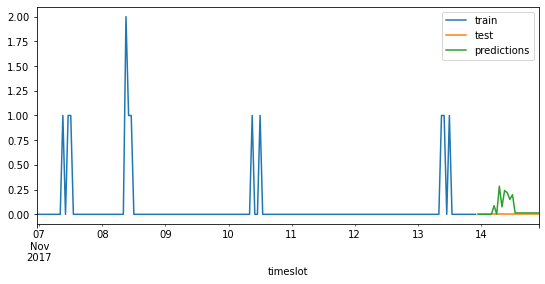

In [7]:
predictions = forecaster.predict(steps=units_to_forecast)

predictions.index = test.index

actual = train[-7*24:]

fig, ax = plt.subplots(figsize=(9, 4))
actual['num_kwh'].plot(ax=ax, label='train')
test['num_kwh'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
error_mse = mean_squared_error(
                y_true = test['num_kwh'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 1 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [24, 48, 7*24, 14*24]

# Regressor's hyperparameters
param_grid = {'n_estimators': [i for i in range(50,100,1)],
              'max_depth': [i for i in range(3,10,1)]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train_series[:24*365]['num_kwh'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = units_to_forecast,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)),
                        return_best        = True,
                        fixed_train_size   = True,
                        verbose            = False
               )
results_grid

Number of models compared: 245


loop param_grid:  37%|█████████████▎                      | 13/35 [00:14<00:28,  1.31s/it]

In [ ]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = train_series[:]['num_kwh'],
                            initial_train_size = 24*365,
                            steps      = units_to_forecast,
                            refit      = True,
                            interval   = [5/2, 100-5/2],
                            n_boot     = 500,
                            metric     = 'mean_squared_error',
                            fixed_train_size   = True,
                            verbose    = True
                        )
predictions.head(4)

In [ ]:
prediction.to_csv("final_predictions_prod.csv")
metric.to_csv("final_metrics_prod.csv")

In [ ]:
predictions.index = train_series[24*365:]['num_kwh'].index

fig, ax=plt.subplots(figsize=(22, 6))
predictions['pred'].plot(ax=ax, label='predictions', color="green", alpha=0.5)
train_series[24*365:]['num_kwh'].plot(ax=ax, label='test', color="darkorange", alpha=0.5)
train_series[:24*365]['num_kwh'].plot(ax=ax, label='train', color="blue")
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'deepskyblue',
    alpha = 0.3,
    label = '95% interval'
)
#ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('kwh')
ax.set_title('Energy demand forecast')
ax.legend();

inside_interval = np.where(
                     (train_series.loc[predictions.index, 'num_kwh'] >= predictions['lower_bound']) & \
                     (train_series.loc[predictions.index, 'num_kwh'] <= predictions['upper_bound']),
                     True,
                     False
                  )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * coverage}%")

In [ ]:
#predictions = pd.read_csv("final_predictions_prod.csv")
#predictions.index = predictions['timeslot']

error_rmse = np.sqrt(mean_squared_error(
                y_true = train_series[24*365:]['num_kwh'],
                y_pred = predictions['pred']
            ))

print(f"RMSE of RF: {error_rmse}")

naive_model = np.zeros((len(predictions)))

naive_rmse = np.sqrt(mean_squared_error(
                y_true = train_series[24*365:]['num_kwh'],
                y_pred = naive_model
            ))
print(f"Naive model (zeroes) (rmse): {naive_rmse}")

naive_model2 = np.ones((len(predictions)))*np.mean(train_series[24*365:]['num_kwh'])

naive_rmse2 = np.sqrt(mean_squared_error(
                y_true = train_series[24*365:]['num_kwh'],
                y_pred = naive_model2
            ))

print(f"Naive model (mean) (rmse): {naive_rmse2}")

naive_model3 = train_series[24*365-24*7:-24*7]
naive_model3.index = train_series[24*365:].index

naive_rmse3 = np.sqrt(mean_squared_error(
                y_true = train_series[24*365:]['num_kwh'],
                y_pred = naive_model3['num_kwh']
            ))

print(f"Naive model (last week) (rmse): {naive_rmse3}")
